# IMPORTS

In [1]:
import torch
torch.__version__

'1.8.0'

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms, models
import copy
import time
from collections import OrderedDict
from PIL import Image
from typing import Any
import math
import operator
import functools
import cv2

# LOADING TRAIN SET (IMAGES, LABELS) FROM .mat FILE 

In [3]:
images_mat = scipy.io.loadmat('/Users/hassaanmuzammil/Desktop/dtd_white_indoor_6600artimg.mat')
labels_mat = scipy.io.loadmat('/Users/hassaanmuzammil/Desktop/dtd_white_indoor_6600corners.mat')

In [4]:
images = images_mat['allartimgs1']
labels = labels_mat['allcorners1']

# DISPLAYING AN IMAGE AND CORRESPONDING LABEL (FOUR CORNERS)

IMAGE DIMENSIONS: 384,256,3

LABEL DIMENSIONS: 8 (x,y coordinate for all 4 corners, hence 8)

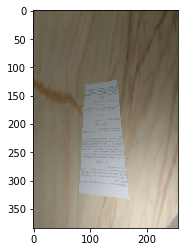

In [5]:
plt.imshow(images[6000])
plt.show()

In [6]:
labels[6000]

array([ 92.32125984, 132.37606838, 148.76220472, 124.17094017,
       169.72598425, 334.22222222,  81.83937008, 323.28205128])

# TRANSFORMING AND LOADING DATASET IN BATCHES

In [7]:
transforms = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
images = torch.tensor(images,dtype=torch.float)
labels = torch.tensor(labels,dtype=torch.float)
train_set = [images, labels]

In [9]:
print(images.shape)
print(labels.shape)

torch.Size([6615, 384, 256, 3])
torch.Size([6615, 8])


In [10]:
images = torch.transpose(torch.transpose(images,3,1),2,3)

In [11]:
images.size()

torch.Size([6615, 3, 384, 256])

In [12]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(images, labels)
train_dataloader = DataLoader(train_dataset, batch_size=1)

In [13]:
batch = next(iter(train_dataloader))
print(batch[0].shape)
print(batch[1].shape)

torch.Size([1, 3, 384, 256])
torch.Size([1, 8])


# DOWNLOADING SQUEEZENET PYTORCH WITH PRETRAINED WEIGHTS

In [14]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_0', pretrained=True)

Using cache found in /Users/hassaanmuzammil/.cache/torch/hub/pytorch_vision_v0.9.0


# MODEL PARAMETER STATISTICS 

In [15]:
for param in model.parameters():
    param.requires_grad=False
    
classifier = nn.Linear(1000,8)
model.fc = classifier

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

1,256,432 total parameters.
8,008 trainable parameters.


# MODEL ARCHITECTURE

Utilizing transfer learning by forming a fully connected layer at the end.

In [16]:
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

# FORWARD PASS TEST

In [17]:
t = torch.rand(1,3,384,256)
out = model.forward(t)
out = model.fc(out)
out.shape

torch.Size([1, 8])

# DEFINING LOSS FUNCTION, OPTIMIZER, SCHEDULER

In [18]:
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

# TRAINING THE MODEL

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10,device='cuda'):
      train_loss = []
      for epoch in range(num_epochs):  # loop over the dataset multiple times
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            running_loss = 0.0

            for inputs,labels in train_dataloader:
                # get the inputs; data is a list of [inputs, labels]
                #inputs = inputs.cuda()
                #label = label.cuda()

                #print(inputs.shape)
                #print(labels.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                outputs = classifier(outputs)

                #print(outputs.shape)

                loss = criterion(outputs.flatten(), labels.flatten())
                #print('Loss in iteration: ',i,'is equal to ',loss)

                #loss.requires_grad = True
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()


            train_loss.append(running_loss/6615)
            print('Train Loss: ',train_loss[-1])
            running_loss = 0.0
      return train_loss

In [20]:
#train_loss = train_model(model, loss_fn, optimizer, scheduler)

Epoch 0/9
----------
Train Loss: 218074.6788
Epoch 1/9
----------
Train Loss: 168074.6788
Epoch 2/9
----------
Train Loss: 178144.0021
Epoch 3/9
----------
Train Loss: 138144.2122
Epoch 4/9
----------
Train Loss: 133621.986
Epoch 5/9
----------
Train Loss: 144422.5499
Epoch 6/9
----------
Train Loss: 122309.0193
Epoch 7/9
----------
Train Loss: 100222.9832
Epoch 8/9
----------
Train Loss: 83574.7712
Epoch 9/9
----------
Train Loss: 93923.9382


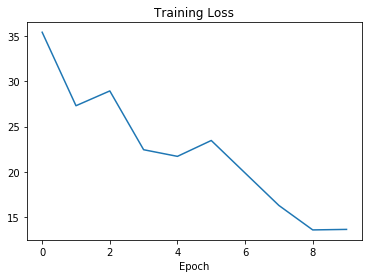

In [22]:
train_loss = [i/6155 for i in train_loss] #normalized train loss
plt.figure()
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.title('Training Loss')
plt.show()

# TESTING MODEL PREDICTIONS ON TRAINING IMAGE

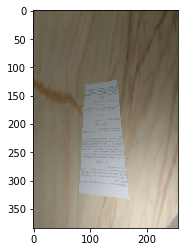

Original corners from training set:  tensor([ 92.3213, 132.3761, 148.7622, 124.1709, 169.7260, 334.2222,  81.8394,
        323.2820])
-------------------------------------------------
Predicted Corners after SQUEEZENET training:  tensor([ 86, 131, 141, 120, 179, 343,  81, 333])


In [26]:
im1 = images_mat['allartimgs1'][6000]
plt.imshow(im1)
plt.show()

out1 = model.forward(im1)
out1 = torch.tensor(out1,dtype=torch.int)

print('Original corners from training set: ',labels[6000])
print('-------------------------------------------------')
print('Predicted Corners after SQUEEZENET training: ',out1.flatten())

# GEOMETRIC TRANSFORMATION

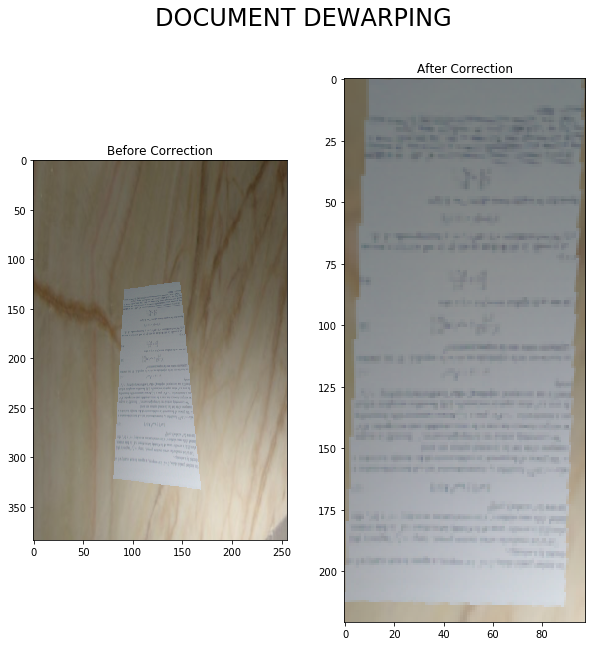

In [27]:
# All points are in format [cols, rows]
pt_A = [86, 132] #topleft
pt_B = [81, 333] #bottomleft
pt_C = [179,343] #bottomright
pt_D = [148,124] #topright

# Here, I have used L2 norm. You can use L1 also.
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))



# Specify input and output coordinates that is used
# to calculate the transformation matrix

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

 
# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)
 
# Apply the perspective transformation to the image
out = cv2.warpPerspective(im1,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
 
# Display the transformed image
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Before Correction')
plt.imshow(im1)

plt.subplot(1,2,2)
plt.title('After Correction')
plt.imshow(out)

plt.suptitle('DOCUMENT DEWARPING', fontsize=24)
plt.show()

## With better training time and more epochs, we can improve the accuracy of the model further..

# TESTING MODEL PREDICTIONS ON NEW IMAGE

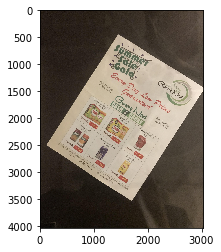

In [29]:
im1 = plt.imread('/Users/hassaanmuzammil/Downloads/Image1.jpeg')
plt.imshow(im1)
plt.show()

In [31]:
out1 = torch.tensor(model.forward(im1),dtype=torch.int)
print('Original corners: ',[1457,462,137,2469,1686,3506,3017,1444])
print('-------------------------------------------------------------')
print('Predicted Corners after SQUEEZENET training: ',out1.flatten())

Original corners:  [1457, 462, 137, 2469, 1686, 3506, 3017, 1444]
-------------------------------------------------------------
Predicted Corners after SQUEEZENET training:  tensor([1452,  460,  147, 2470, 1685, 3505, 3009, 1441])


# GEOMETRIC TRANSFORMATION

Applied using four corners and image corrected using homography

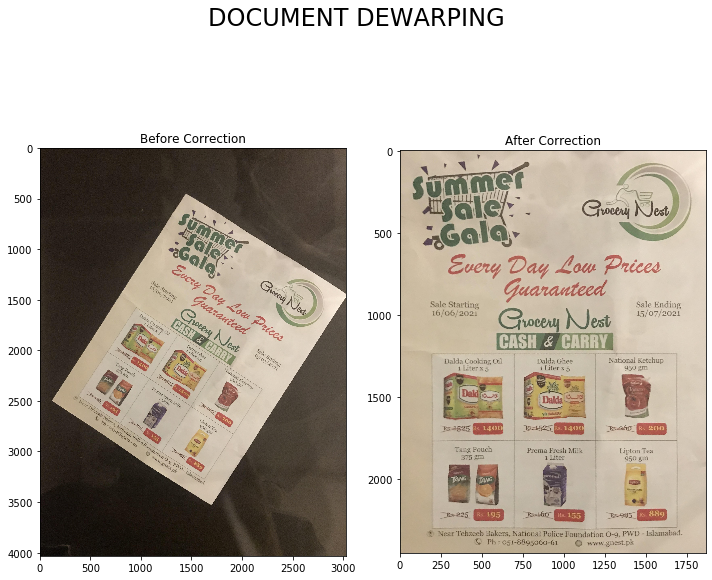

In [32]:
# All points are in format [cols, rows]

#using ideal points
pt_A = [1457, 462] #topleft
pt_B = [137, 2469] #bottomleft
pt_C = [1686,3506] #bottomright
pt_D = [3017,1444] #topright

# Here, I have used L2 norm. You can use L1 also.
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))



# Specify input and output coordinates that is used
# to calculate the transformation matrix

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

 
# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)
 
# Apply the perspective transformation to the image
out = cv2.warpPerspective(im1,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
 
# Display the transformed image
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Before Correction')
plt.imshow(im1)

plt.subplot(1,2,2)
plt.title('After Correction')
plt.imshow(out)

plt.suptitle('DOCUMENT DEWARPING', fontsize=24)
plt.tight_layout()
plt.show()